# Do Not Execute Cells

### AlphaVantage website
https://www.alphavantage.co/

API documentation <br>
https://www.alphavantage.co/documentation/

Need to create account to gain access to own API key.

In [1]:
import pandas as pd
import numpy as np

import requests

import matplotlib.pyplot as plt

In [2]:
with open('alpha_vantage.txt.nogit', 'r') as f:
    API_key = f.readline()

In [3]:
def AV_request(symbol, function='TIME_SERIES_DAILY_ADJUSTED', 
               outputsize='compact', API_key=API_key): # 'compact' gives last 100 data points
    """Reads in the daily series data, and converts the types
    to numbers or dates, as appropriate.  
    
    See https://www.alphavantage.co/documentation/
    for documentation on the AlphaVantage API.  
    """
    url = f'https://www.alphavantage.co/query?function={function}&symbol={symbol}&outputsize={outputsize}&apikey={API_key}'
    response = requests.get(url)
    
    df = pd.DataFrame(response.json()['Time Series (Daily)'])
    df = df.transpose().astype(np.float32) # want dates as index not cols; convert strings to numbers!
    df.index = pd.to_datetime(df.index)    # numbers to datetime objects
    df = df.rename(columns={c: c.split()[1] for c in df.columns}).sort_index()
    
    return df

In [4]:
df = AV_request('IBM', outputsize='full')

In [5]:
df.head(10)

,open,high,low,close,adjusted,volume,dividend,split
1999-11-01,98.500000,98.809998,96.370003,96.750000,61.535099,9551800.0,0.00,1.0
1999-11-02,96.750000,96.809998,93.690002,94.809998,60.301201,11105400.0,0.00,1.0
1999-11-03,95.870003,95.940002,93.500000,94.370003,60.021400,10369100.0,0.00,1.0
1999-11-04,94.440002,94.440002,90.000000,91.559998,58.234200,16697600.0,0.00,1.0
1999-11-05,92.750000,92.940002,90.190002,90.250000,57.401001,13737600.0,0.00,1.0
1999-11-08,90.500000,93.940002,90.500000,93.940002,59.824200,8522300.0,0.12,1.0
1999-11-09,95.059998,95.500000,92.120003,93.620003,59.620399,9551200.0,0.00,1.0
1999-11-10,94.620003,97.059998,94.120003,97.000000,61.772900,8680300.0,0.00,1.0
1999-11-11,97.500000,97.500000,94.870003,95.000000,60.499298,7147500.0,0.00,1.0
1999-11-12,96.000000,96.250000,93.000000,95.870003,61.053299,9668400.0,0.00,1.0


In [6]:
df.info() # no missing data!

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5293 entries, 1999-11-01 to 2020-11-11
Data columns (total 8 columns):
open        5293 non-null float32
high        5293 non-null float32
low         5293 non-null float32
close       5293 non-null float32
adjusted    5293 non-null float32
volume      5293 non-null float32
dividend    5293 non-null float32
split       5293 non-null float32
dtypes: float32(8)
memory usage: 206.8 KB


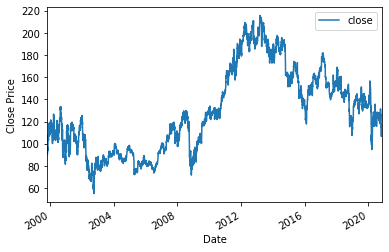

In [7]:
column, label = 'close', 'Close Price' # plot closing price TS

df.reset_index().plot(x='index', y=column)
plt.xlabel('Date')
plt.ylabel(label);

### Rolling average
Let's compute (and graph) a rolling average of the time series.

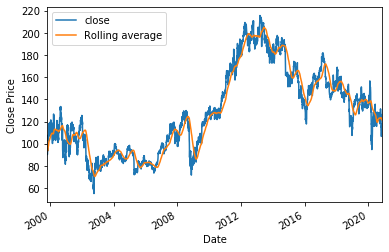

In [8]:
periods = 100
rolling = df[column].rolling(periods, min_periods=1).mean()

df.reset_index().plot(x='index', y=column)
plt.xlabel('Date')
plt.ylabel(label)
plt.plot(rolling, label='Rolling average')
plt.legend();

###  A decomposition of the time series

Let's use a tool in `statsmodels` to decompose the time series into a "trend", a "seasonal component", and "residuals".  This is described as a "naive method" in the documentation, but it can give us a "big picture" about the time series.  

In order to use this method, however, we must have a time series that has a specific frequency.  Our stock market data doesn't have a fequency, since we have data for (about) five days out of every seven.  

So let's first resample the data, on a weekly basis (say, for demonstration purposes).  

In [9]:
resampled = df.resample('1W').ffill()

In [10]:
resampled.head(5)

,open,high,low,close,adjusted,volume,dividend,split
1999-11-07,92.750000,92.940002,90.190002,90.250000,57.401001,13737600.0,0.0,1.0
1999-11-14,96.000000,96.250000,93.000000,95.870003,61.053299,9668400.0,0.0,1.0
1999-11-21,99.000000,105.120003,98.370003,103.940002,66.192596,19678400.0,0.0,1.0
1999-11-28,105.940002,106.000000,104.120003,105.000000,66.867599,3108400.0,0.0,1.0
1999-12-05,109.809998,112.870003,107.940002,111.870003,71.242699,14680300.0,0.0,1.0


In [11]:
resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1098 entries, 1999-11-07 to 2020-11-15
Freq: W-SUN
Data columns (total 8 columns):
open        1098 non-null float32
high        1098 non-null float32
low         1098 non-null float32
close       1098 non-null float32
adjusted    1098 non-null float32
volume      1098 non-null float32
dividend    1098 non-null float32
split       1098 non-null float32
dtypes: float32(8)
memory usage: 42.9 KB


In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
seasonal_decompose?

In [14]:
decomp = seasonal_decompose(x=resampled, model='additive') # naive additive assumption

decomp.seasonal.head(5)

/opt/conda/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


,open,high,low,close,adjusted,volume,dividend,split
1999-11-07,-1.442294,-1.444706,-1.465308,-1.535571,-1.218688,-1.600391e+05,-0.007939,5.879933e-11
1999-11-14,-2.074932,-1.895138,-2.184083,-2.150662,-1.877390,9.692079e+04,-0.007939,6.462010e-11
1999-11-21,-2.147770,-2.445641,-2.429188,-2.482280,-2.182038,-1.119514e+05,0.019561,-9.254059e-11
1999-11-28,-3.171634,-3.121485,-2.961230,-3.122956,-2.598120,-6.457003e+05,0.057061,5.879933e-11
1999-12-05,-3.142711,-3.023138,-3.002282,-2.810450,-2.030376,-1.239691e+06,-0.007939,1.402901e-10


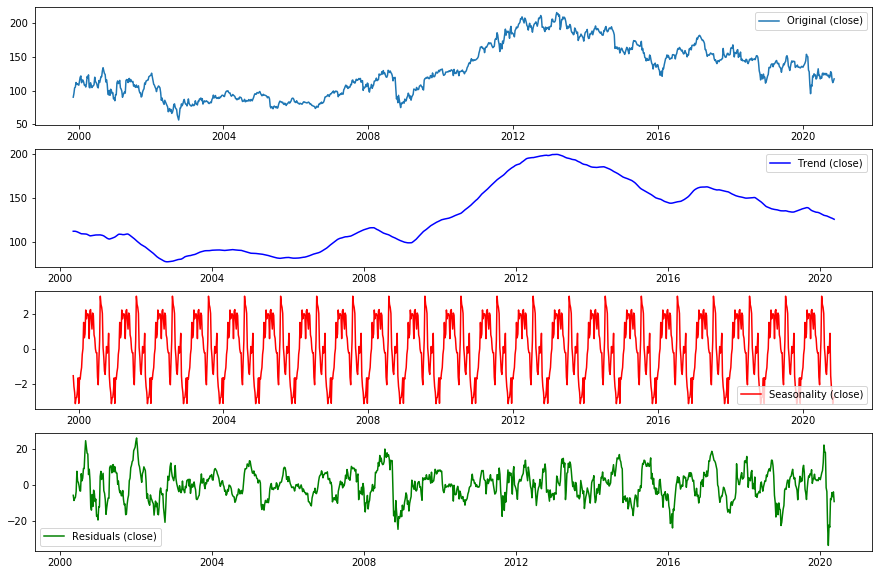

In [15]:
fig, axes = plt.subplots(4, 1)
fig.set_figheight(10)
fig.set_figwidth(15)
axes[0].plot(resampled[column], label=f'Original ({column})')
axes[0].legend()
axes[1].plot(decomp.trend[column], label=f'Trend ({column})',color="b")
axes[1].legend()
axes[2].plot(decomp.seasonal[column], label=f'Seasonality ({column})',color='r')
axes[2].legend()
axes[3].plot(decomp.resid[column], label=f'Residuals ({column})',color='g')
axes[3].legend();

### ARIMA modeling

In particular, this is a seasonal ARIMA model we will build here.  Given that we have weekly data, let's consider this to have a seasonal period of 52 (weeks).  This may or may not be a good assumption, but upon "eyeballing" the seasonal graph above might be a good starting point.  

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

/opt/conda/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [5]:
SARIMAX?
# With eXogenous regressors (not used here)

In [43]:
model = SARIMAX(resampled[column], trend=[1,1,1], order=(2,2,1), seasonal_order=(1,0,0,52))
# orders chosen arbitrarily for illustration

In [44]:
res = model.fit()

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [45]:
print(res.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              close   No. Observations:                 1098
Model:             SARIMAX(2, 2, 1)x(1, 0, 0, 52)   Log Likelihood               -3256.727
Date:                            Wed, 11 Nov 2020   AIC                           6529.455
Time:                                    22:26:17   BIC                           6569.450
Sample:                                11-07-1999   HQIC                          6544.588
                                     - 11-15-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0978      0.155     -0.631      0.528      -0.401       0.206
drift          0.0003      0.001   

In [32]:
res.predict().head()

1999-11-07     -0.042851
1999-11-14    135.315005
1999-11-21    101.452419
1999-11-28    110.636402
1999-12-05    110.144379
Freq: W-SUN, dtype: float64

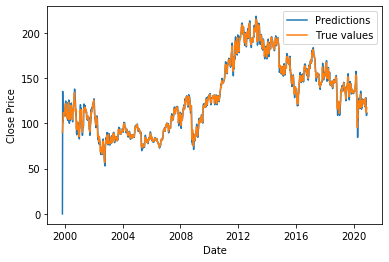

In [46]:
plt.plot(res.predict(), label='Predictions')
plt.plot(resampled[column], label="True values")
plt.xlabel('Date')
plt.ylabel(label)
plt.legend();

In [37]:
resampled.tail()

,open,high,low,close,adjusted,volume,dividend,split
2020-10-18,125.169998,126.430000,124.654999,125.930000,124.178001,4714320.0,0.0,1.0
2020-10-25,116.500000,116.620003,115.529999,116.000000,114.386101,3893362.0,0.0,1.0
2020-11-01,107.900002,111.800003,107.750000,111.660004,110.106499,7923882.0,0.0,1.0
2020-11-08,115.080002,115.099998,113.389999,114.040001,112.453400,5249171.0,0.0,1.0
2020-11-15,118.120003,118.349998,116.220001,117.199997,117.199997,4202415.0,0.0,1.0


In [35]:
res.predict?

In [47]:
res.predict(start="2020-11-15", end="2021-01-31")

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


2020-11-15    111.300919
2020-11-22    116.638914
2020-11-29    116.763049
2020-12-06    116.747053
2020-12-13    116.876892
2020-12-20    117.022570
2020-12-27    117.005462
2021-01-03    116.916454
2021-01-10    117.080389
2021-01-17    117.162145
2021-01-24    117.275138
2021-01-31    117.443416
Freq: W-SUN, dtype: float64